In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import heapq

In [ ]:
import os

file_path = "/content/drive/MyDrive/Track2"   # path to your folder


In [ ]:
import networkx as nx
import glob  # Used to find files
import os    # Used for path manipulation
import time  # To time the algorithm
import pandas as pd # To store results in a table
from google.colab import drive

# --- 1. Mount your Google Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("Drive mounted.")

# --- 2. The STEINLIB Parser Function (Unchanged) ---

def parse_steinlib_gr(file_path):
    """
    Parses a .gr file in the STEINLIB (SECTION-based) format.
    """
    G = nx.Graph()
    terminals = []
    current_section = None
    filename = os.path.basename(file_path)

    try:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith("c"):
                    continue

                if line.startswith("SECTION Graph"):
                    current_section = "GRAPH"
                elif line.startswith("SECTION Terminals"):
                    current_section = "TERMINALS"
                elif line.startswith("SECTION"):
                    current_section = "OTHER"
                elif line.startswith("END"):
                    current_section = None
                elif line.startswith("EOF"):
                    break

                parts = line.split()
                if not parts:
                    continue

                if current_section == "GRAPH":
                    if parts[0] == 'E' and len(parts) == 4:
                        try:
                            G.add_edge(int(parts[1]), int(parts[2]), weight=int(parts[3]))
                        except ValueError:
                            print(f"Warning ({filename}): Skipping malformed edge line: {line}")

                elif current_section == "TERMINALS":
                    if parts[0] == 'T' and len(parts) == 2:
                        try:
                            terminals.append(int(parts[1]))
                        except ValueError:
                            print(f"Warning ({filename}): Skipping malformed terminal line: {line}")
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return None, None
    return G, terminals

# --- 3. Batch-Load all instances (UPDATED with file size filter) ---

print("\n--- Starting batch-load from Google Drive ---")
folder_path = "/content/drive/MyDrive/Track2"
all_instances = {}
MAX_FILE_SIZE_KB = 25 # Maximum file size in KB

if os.path.isdir(folder_path):
    file_pattern = os.path.join(folder_path, "instance*.gr")
    gr_files = sorted(glob.glob(file_pattern))

    if not gr_files:
        print(f"Warning: No files found matching '{file_pattern}'")
    else:
        print(f"Found {len(gr_files)} instance(s). Filtering by size...")
        filtered_files = []
        for file_path in gr_files:
            if os.path.getsize(file_path) <= MAX_FILE_SIZE_KB * 1024: # Convert KB to bytes
                filtered_files.append(file_path)
            # else:
                # print(f"  > Skipping '{os.path.basename(file_path)}' (size > {MAX_FILE_SIZE_KB} KB)")


        if not filtered_files:
            print(f"Warning: No files found under {MAX_FILE_SIZE_KB} KB matching '{file_pattern}'")
        else:
            print(f"Found {len(filtered_files)} instance(s) under {MAX_FILE_SIZE_KB} KB. Parsing...")
            for file_path in filtered_files:
                instance_name = os.path.splitext(os.path.basename(file_path))[0]
                G, T = parse_steinlib_gr(file_path)
                if G is not None and T is not None:
                    all_instances[instance_name] = {'graph': G, 'terminals': T}
                    # To reduce clutter, I'm commenting out the load-by-load print
                    # print(f"  > Loaded '{instance_name}': {G.number_of_nodes()} N, {G.number_of_edges()} E, {len(T)} T")
    print(f"--- Batch-load complete: {len(all_instances)} instances loaded ---")
else:
    print(f"Error: Folder not found at '{folder_path}'. Did you mount your Drive?")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted.

--- Starting batch-load from Google Drive ---
Found 200 instance(s). Filtering by size...
Found 78 instance(s) under 25 KB. Parsing...
--- Batch-load complete: 78 instances loaded ---


In [ ]:
optimal_csv_path = "/content/track2.csv" #
optimal_costs = {}
try:
    optimal_df = pd.read_csv(optimal_csv_path)
    print("\n--- Optimal Solutions CSV Head ---")
    print(optimal_df.head())

    # ===! IMPORTANT !===
    # Adjust these column names to match your CSV file
    # I'm GUESSING the column names are 'instance' and 'optimal_solution'
    INSTANCE_COL = 'paceName' # Change this if needed
    OPTIMAL_COL = 'opt'  # Change this if needed
    # ====================

    # Clean the instance name (e.g., 'instance001.gr' -> 'instance001') and strip whitespace
    optimal_df['Instance_Clean'] = optimal_df[INSTANCE_COL].str.replace('.gr', '', regex=False).str.strip()

    # Convert to a dictionary for fast lookup
    optimal_costs = optimal_df.set_index('Instance_Clean')[OPTIMAL_COL].to_dict()
    print(f"Successfully loaded {len(optimal_costs)} optimal solutions.")

except FileNotFoundError:
    print(f"Warning: Optimal solutions file not found at {optimal_csv_path}")
    print("Optimal costs will not be included in the results.")
except Exception as e:
    print(f"Error loading optimal solutions: {e}")
    print("Please check the column names (INSTANCE_COL, OPTIMAL_COL) in the script.")


--- Optimal Solutions CSV Head ---
          paceName        opt
0  instance001.gr        1086
1  instance002.gr         626
2  instance003.gr       41350
3  instance004.gr       54160
4  instance005.gr   764269099
Successfully loaded 200 optimal solutions.


In [ ]:
# --- 4. KMB Algorithm Implementation ---

import time
start_time_kmb = time.time()

def kmb_steiner_tree(G, terminals):
    """
    Solves the Steiner tree problem using the Kou, Markowsky, and Berman (KMB) approximation algorithm.

    Args:
        G: A NetworkX graph with non-negative edge weights.
        terminals: A list of terminal nodes that must be included in the tree.

    Returns:
        A tuple containing:
            - A set of nodes forming the approximate Steiner tree found.
            - A list of edges forming the approximate Steiner tree found.
            - The total weight of the approximate Steiner tree.
            Returns (set(), [], float('inf')) if terminals are less than 2 or no paths exist between terminals.
    """
    if len(terminals) < 2:
        print("KMB algorithm requires at least two terminal nodes.")
        return set(), [], float('inf')

    # 1. Compute all-pairs shortest paths between all terminal nodes
    terminal_pairs_shortest_paths = {}
    terminal_pairs_shortest_distances = {}

    for i in range(len(terminals)):
        for j in range(i + 1, len(terminals)):
            source = terminals[i]
            target = terminals[j]
            try:
                path = nx.shortest_path(G, source=source, target=target, weight='weight')
                distance = nx.shortest_path_length(G, source=source, target=target, weight='weight')

                terminal_pairs_shortest_paths[(source, target)] = path
                terminal_pairs_shortest_paths[(target, source)] = list(reversed(path))
                terminal_pairs_shortest_distances[(source, target)] = distance
                terminal_pairs_shortest_distances[(target, source)] = distance

            except nx.NetworkXNoPath:
                print(f"Warning: No path found between terminal nodes {source} and {target}. KMB might not find a connected tree.")


    # 2. Construct the metric closure graph
    metric_closure_graph = nx.Graph()
    metric_closure_graph.add_nodes_from(terminals)

    for (u, v), dist in terminal_pairs_shortest_distances.items():
        if u < v:
             metric_closure_graph.add_edge(u, v, weight=dist)

    if not nx.is_connected(metric_closure_graph):
         print("Warning: Metric closure graph is not connected. Not all terminals are reachable from each other.")
         return set(), [], float('inf')


    # 3. Compute the Minimum Spanning Tree (MST) of the metric closure graph
    try:
        mst_metric_closure = nx.minimum_spanning_tree(metric_closure_graph, weight='weight')




    except nx.NetworkXNoCycle:
         print("Error: Could not compute MST of the metric closure graph.")
         return set(), [], float('inf')


    # 4. Combine all nodes and edges from the shortest paths in the original graph G
    # corresponding to the edges in the MST of the metric closure graph.
    combined_subgraph_nodes = set()
    combined_subgraph_edges = set()

    for u, v in mst_metric_closure.edges():
        path = terminal_pairs_shortest_paths.get((u, v))
        if path is None:
            path = terminal_pairs_shortest_paths.get((v, u))

        if path:
            combined_subgraph_nodes.update(path)
            path_edges = list(nx.utils.pairwise(path))
            for edge_u, edge_v in path_edges:
                 combined_subgraph_edges.add(tuple(sorted((edge_u, edge_v))))

    # Create a subgraph from the combined nodes and edges
    final_kmb_subgraph = nx.Graph()
    final_kmb_subgraph.add_nodes_from(list(combined_subgraph_nodes))
    for u, v in combined_subgraph_edges:
        if G.has_edge(u, v):
            final_kmb_subgraph.add_edge(u, v, weight=G[u][v]['weight'])
        elif G.has_edge(v, u):
             final_kmb_subgraph.add_edge(v, u, weight=G[v][u]['weight'])


    # 6. Compute the MST of this combined subgraph
    if not nx.is_connected(final_kmb_subgraph):
         print("Error: Final combined subgraph is not connected.")
         return set(), [], float('inf')

    try:
        kmb_mst = nx.minimum_spanning_tree(final_kmb_subgraph, weight='weight')
        final_kmb_tree_nodes = set(kmb_mst.nodes())
        final_kmb_tree_edges = list(kmb_mst.edges())
        final_kmb_weight = sum(kmb_mst[u][v]['weight'] for u, v in kmb_mst.edges())

        if all(term in final_kmb_tree_nodes for term in terminals):
             return final_kmb_tree_nodes, final_kmb_tree_edges, final_kmb_weight
        else:
             print("Error: Not all terminals are included in the final KMB MST.")
             return set(), [], float('inf')

    except nx.NetworkXNoCycle:
         print("Error: Could not compute MST of the final KMB subgraph.")
         return set(), [], float('inf')



In [ ]:
import heapq
import networkx as nx
import time

def greedy_steiner_tree(G, terminals):
    """
    Optimized Greedy Steiner Tree:
    - Retains greedy expansion nature.
    - Much faster than naive greedy and KMB.
    """
    if not terminals:
        return set(), [], float('inf')

    start_time = time.time()

    # Initialize structures
    tree_nodes = {terminals[0]}
    connected_terminals = {terminals[0]}
    tree_edges = set()
    total_weight = 0.0

    # Mark all nodes initially unvisited
    visited = {n: False for n in G.nodes()}
    for t in tree_nodes:
        visited[t] = True

    # Priority queue: (weight, u, v)
    pq = []
    for u in tree_nodes:
        for v, data in G[u].items():
            heapq.heappush(pq, (data['weight'], u, v))

    while connected_terminals != set(terminals) and pq:
        w, u, v = heapq.heappop(pq)

        if visited[v]:
            continue

        # Add new node/edge to the tree
        visited[v] = True
        tree_edges.add(tuple(sorted((u, v))))
        tree_nodes.add(v)
        total_weight += w

        if v in terminals:
            connected_terminals.add(v)

        # Add v’s neighbors to the heap
        for nbr, data in G[v].items():
            if not visited[nbr]:
                heapq.heappush(pq, (data['weight'], v, nbr))

    # Add an explicit return for the case where the loop finishes without connecting all terminals
    if connected_terminals == set(terminals):
        return tree_nodes, list(tree_edges), total_weight
    else:
        # Could not connect all terminals
        return set(), [], float('inf')

In [ ]:
print("\n--- Running Greedy Algorithm on All Instances ---")

greedy_results_list = []

if not all_instances:
    print("No instances were loaded. Cannot run greedy algorithm.")
else:
    print(f"Running greedy algorithm on {len(all_instances)} instances...")

    # Process instances in sorted order
    for instance_name in sorted(all_instances.keys()):
        data = all_instances[instance_name]
        G = data['graph']
        T = data['terminals']


        try:
            start_time_greedy = time.time()
            nodes_greedy, edges_greedy, total_cost_greedy = greedy_steiner_tree(G, T)
            end_time_greedy = time.time()

            greedy_results_list.append({
                'Instance': instance_name,
                'Algorithm': 'Greedy',
                'Cost': total_cost_greedy,
                'Time (s)': end_time_greedy - start_time_greedy,
                'Terminals': len(T),
                'Nodes': G.number_of_nodes(),
                'Edges': G.number_of_edges(),
                'Solution_Edges': len(edges_greedy),
                'Error': None if total_cost_greedy != float('inf') else "No valid tree found"
            })

        except Exception as e:
            print(f"    ERROR processing '{instance_name}' with Greedy: {e}")
            greedy_results_list.append({
                'Instance': instance_name,
                'Algorithm': 'Greedy',
                'Cost': None,
                'Time (s)': None,
                'Terminals': len(T),
                'Nodes': G.number_of_nodes(),
                'Edges': G.number_of_edges(),
                'Solution_Edges': None,
                'Error': str(e)
            })

    print("--- Greedy Algorithm run complete ---")

if greedy_results_list:
    greedy_results_df = pd.DataFrame(greedy_results_list)

    # Define the order of columns for greedy results
    greedy_columns_order = [
        'Instance', 'Algorithm', 'Cost', 'Time (s)',
        'Terminals', 'Nodes', 'Edges', 'Solution_Edges', 'Error'
    ]
    greedy_final_columns = [col for col in greedy_columns_order if col in greedy_results_df.columns]
    greedy_results_df = greedy_results_df[greedy_final_columns]

    print("\n--- Greedy Algorithm Results Summary (First 10 Rows) ---")
    display(greedy_results_df.head(10))

else:
    print("No greedy results were generated.")


--- Running Greedy Algorithm on All Instances ---
Running greedy algorithm on 78 instances...
--- Greedy Algorithm run complete ---

--- Greedy Algorithm Results Summary (First 10 Rows) ---


,Instance,Algorithm,Cost,Time (s),Terminals,Nodes,Edges,Solution_Edges,Error
0,instance001,Greedy,1379.0,0.000325,25,74,146,72,None
1,instance002,Greedy,666.0,0.000581,70,133,169,132,None
2,instance003,Greedy,49650.0,0.000384,30,87,176,86,None
3,instance004,Greedy,63810.0,0.000863,50,109,202,106,None
4,instance005,Greedy,814118107.0,0.000927,100,201,253,200,None
5,instance006,Greedy,131259.0,0.001215,198,232,256,231,None
6,instance007,Greedy,22152.0,0.001021,100,216,288,215,None
7,instance008,Greedy,23359.0,0.001062,100,226,306,225,None
8,instance009,Greedy,83250257.0,0.001273,100,229,312,228,None
9,instance010,Greedy,23360.0,0.001097,100,230,313,229,None


In [ ]:
print("\n--- Running KMB Algorithm on All Instances ---")

kmb_results_list = []

if not all_instances:
    print("No instances were loaded. Cannot run KMB algorithm.")
else:
    print(f"Running KMB algorithm on {len(all_instances)} instances...")

    # Process instances in sorted order
    for instance_name in sorted(all_instances.keys()):
        data = all_instances[instance_name]
        G = data['graph']
        T = data['terminals']

        print(f"  Processing '{instance_name}' with KMB...")

        try:
            start_time_kmb = time.time()
            nodes_kmb, edges_kmb, total_cost_kmb = kmb_steiner_tree(G, T)
            end_time_kmb = time.time()

            kmb_results_list.append({
                'Instance': instance_name,
                'Algorithm': 'KMB',
                'Cost': total_cost_kmb,
                'Time (s)': end_time_kmb - start_time_kmb,
                'Terminals': len(T),
                'Nodes': G.number_of_nodes(),
                'Edges': G.number_of_edges(),
                'Solution_Edges': len(edges_kmb),
                'Error': None if total_cost_kmb != float('inf') else "No valid tree found"
            })

        except Exception as e:
            print(f"    ERROR processing '{instance_name}' with KMB: {e}")
            kmb_results_list.append({
                'Instance': instance_name,
                'Algorithm': 'KMB',
                'Cost': None,
                'Time (s)': None,
                'Terminals': len(T),
                'Nodes': G.number_of_nodes(),
                'Edges': G.number_of_edges(),
                'Solution_Edges': None,
                'Error': str(e)
            })

    print("--- KMB Algorithm run complete ---")

if kmb_results_list:
    kmb_results_df = pd.DataFrame(kmb_results_list)

    # Define the order of columns for KMB results
    kmb_columns_order = [
        'Instance', 'Algorithm', 'Cost', 'Time (s)',
        'Terminals', 'Nodes', 'Edges', 'Solution_Edges', 'Error'
    ]
    kmb_final_columns = [col for col in kmb_results_df.columns if col in kmb_results_df.columns]
    kmb_results_df = kmb_results_df[kmb_final_columns]

    print("\n--- KMB Algorithm Results Summary (First 10 Rows) ---")
    display(kmb_results_df.head(10))

else:
    print("No KMB results were generated.")


--- Running KMB Algorithm on All Instances ---
Running KMB algorithm on 78 instances...
  Processing 'instance001' with KMB...
  Processing 'instance002' with KMB...
  Processing 'instance003' with KMB...
  Processing 'instance004' with KMB...
  Processing 'instance005' with KMB...
  Processing 'instance006' with KMB...
  Processing 'instance007' with KMB...
  Processing 'instance008' with KMB...
  Processing 'instance009' with KMB...
  Processing 'instance010' with KMB...
  Processing 'instance011' with KMB...
  Processing 'instance012' with KMB...
  Processing 'instance015' with KMB...
  Processing 'instance016' with KMB...
  Processing 'instance017' with KMB...
  Processing 'instance018' with KMB...
  Processing 'instance019' with KMB...
  Processing 'instance020' with KMB...
  Processing 'instance021' with KMB...
  Processing 'instance027' with KMB...
  Processing 'instance028' with KMB...
  Processing 'instance029' with KMB...
  Processing 'instance030' with KMB...
  Processing '

,Instance,Algorithm,Cost,Time (s),Terminals,Nodes,Edges,Solution_Edges,Error
0,instance001,KMB,1184,0.045314,25,74,146,39,None
1,instance002,KMB,663,0.530747,70,133,169,119,None
2,instance003,KMB,45140,0.117381,30,87,176,31,None
3,instance004,KMB,59540,0.424682,50,109,202,53,None
4,instance005,KMB,786585841,1.960985,100,201,253,176,None
5,instance006,KMB,131068,5.764202,198,232,256,224,None
6,instance007,KMB,21384,1.550902,100,216,288,180,None
7,instance008,KMB,22420,1.629206,100,226,306,183,None
8,instance009,KMB,78770793,2.264064,100,229,312,189,None
9,instance010,KMB,22211,1.751210,100,230,313,189,None


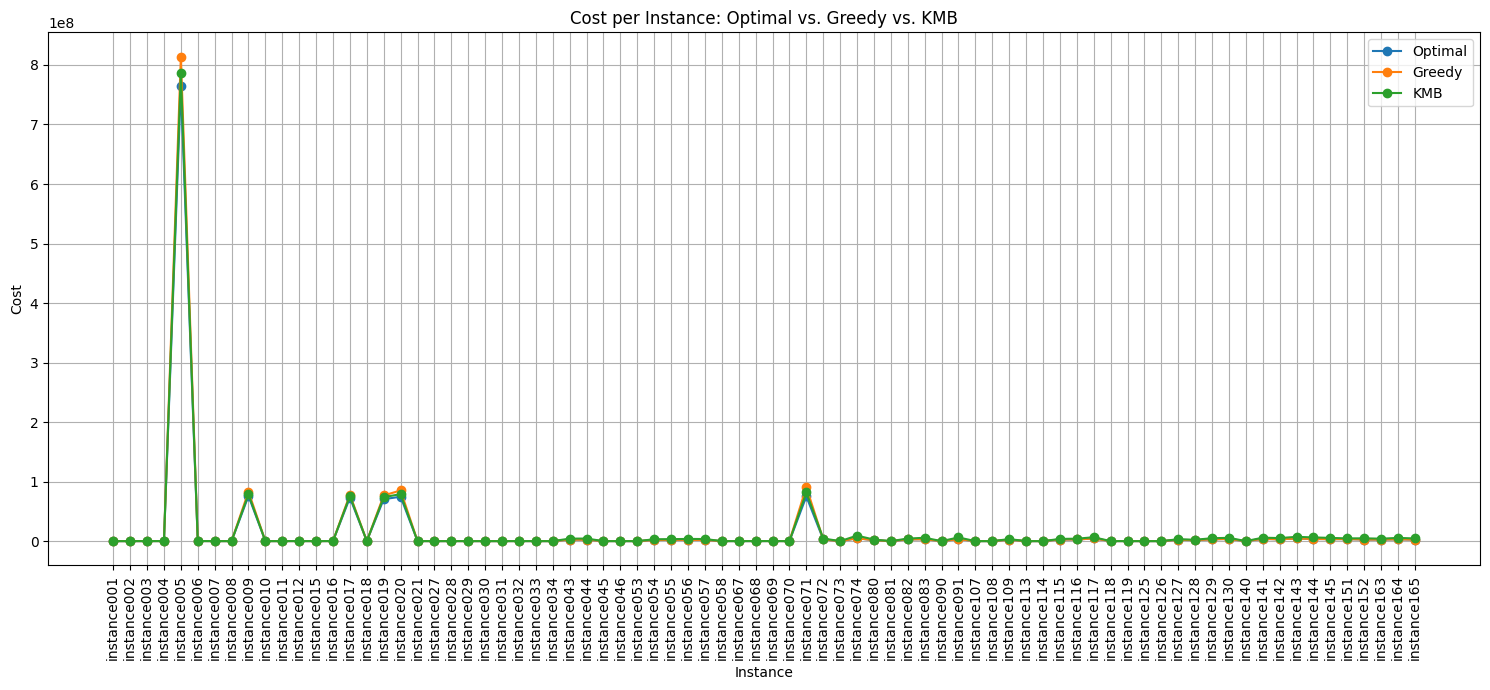

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Merge the greedy and KMB results
algorithm_results_df = pd.concat([greedy_results_df, kmb_results_df])

# Add optimal costs to the results DataFrame
algorithm_results_df['Optimal_Cost'] = algorithm_results_df['Instance'].map(optimal_costs)


# Sort by instance name for consistent plotting
algorithm_results_df = algorithm_results_df.sort_values(by='Instance')

# Create the plot
plt.figure(figsize=(15, 7))

# Plot optimal costs
plt.plot(algorithm_results_df['Instance'].unique(), algorithm_results_df.groupby('Instance')['Optimal_Cost'].first(), marker='o', linestyle='-', label='Optimal')


# Plot algorithm costs
for algorithm in algorithm_results_df['Algorithm'].unique():
    subset_df = algorithm_results_df[algorithm_results_df['Algorithm'] == algorithm]
    plt.plot(subset_df['Instance'], subset_df['Cost'], marker='o', linestyle='-', label=algorithm)

plt.xlabel('Instance')
plt.ylabel('Cost')
plt.title('Cost per Instance: Optimal vs. Greedy vs. KMB')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

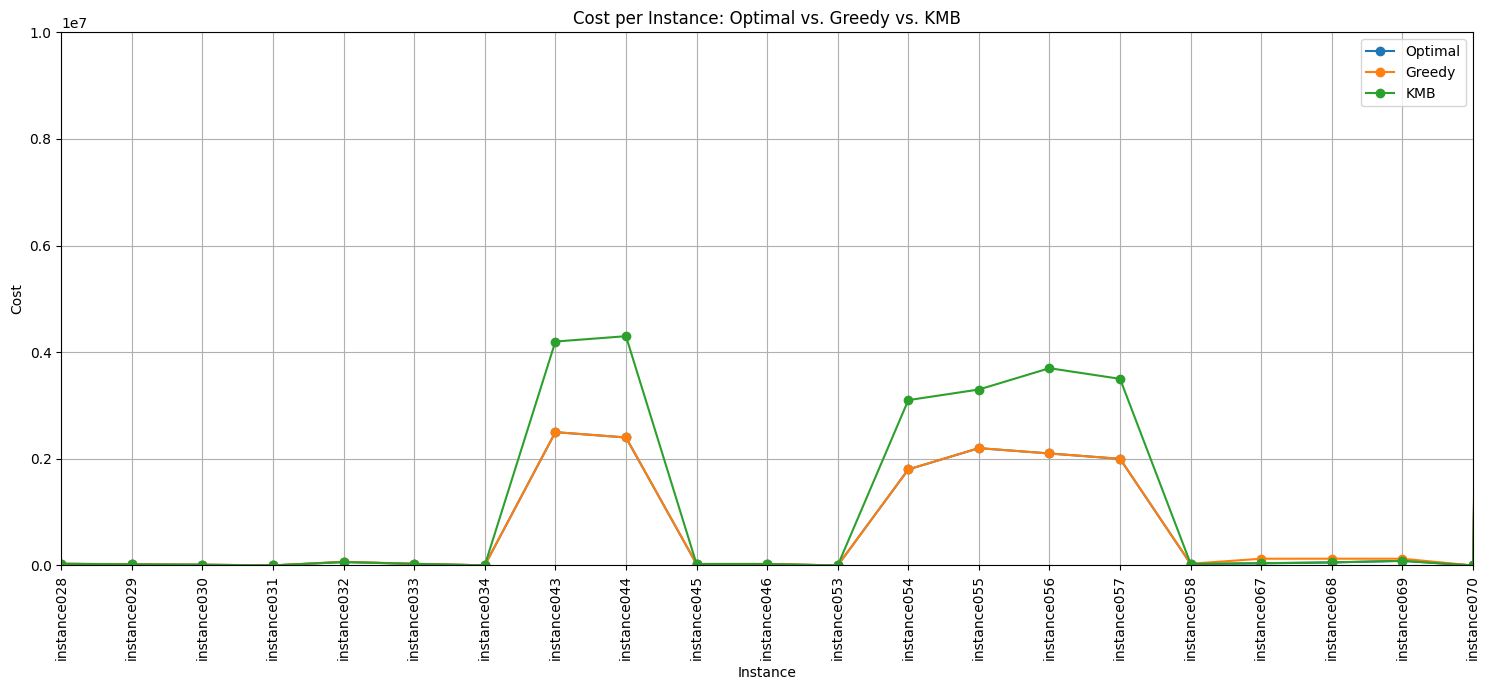

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Merge the greedy and KMB results
algorithm_results_df = pd.concat([greedy_results_df, kmb_results_df])

# Add optimal costs to the results DataFrame
algorithm_results_df['Optimal_Cost'] = algorithm_results_df['Instance'].map(optimal_costs)


# Sort by instance name for consistent plotting
algorithm_results_df = algorithm_results_df.sort_values(by='Instance')

# Create the plot
plt.figure(figsize=(15, 7))

# Plot optimal costs
plt.plot(algorithm_results_df['Instance'].unique(), algorithm_results_df.groupby('Instance')['Optimal_Cost'].first(), marker='o', linestyle='-', label='Optimal')


# Plot algorithm costs
for algorithm in algorithm_results_df['Algorithm'].unique():
    subset_df = algorithm_results_df[algorithm_results_df['Algorithm'] == algorithm]
    plt.plot(subset_df['Instance'], subset_df['Cost'], marker='o', linestyle='-', label=algorithm)
plt.xlabel('Instance')
plt.ylabel('Cost')
plt.title('Cost per Instance: Optimal vs. Greedy vs. KMB')
plt.xticks(rotation=90)
plt.xlim(20,40)
plt.ylim(0,10000000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

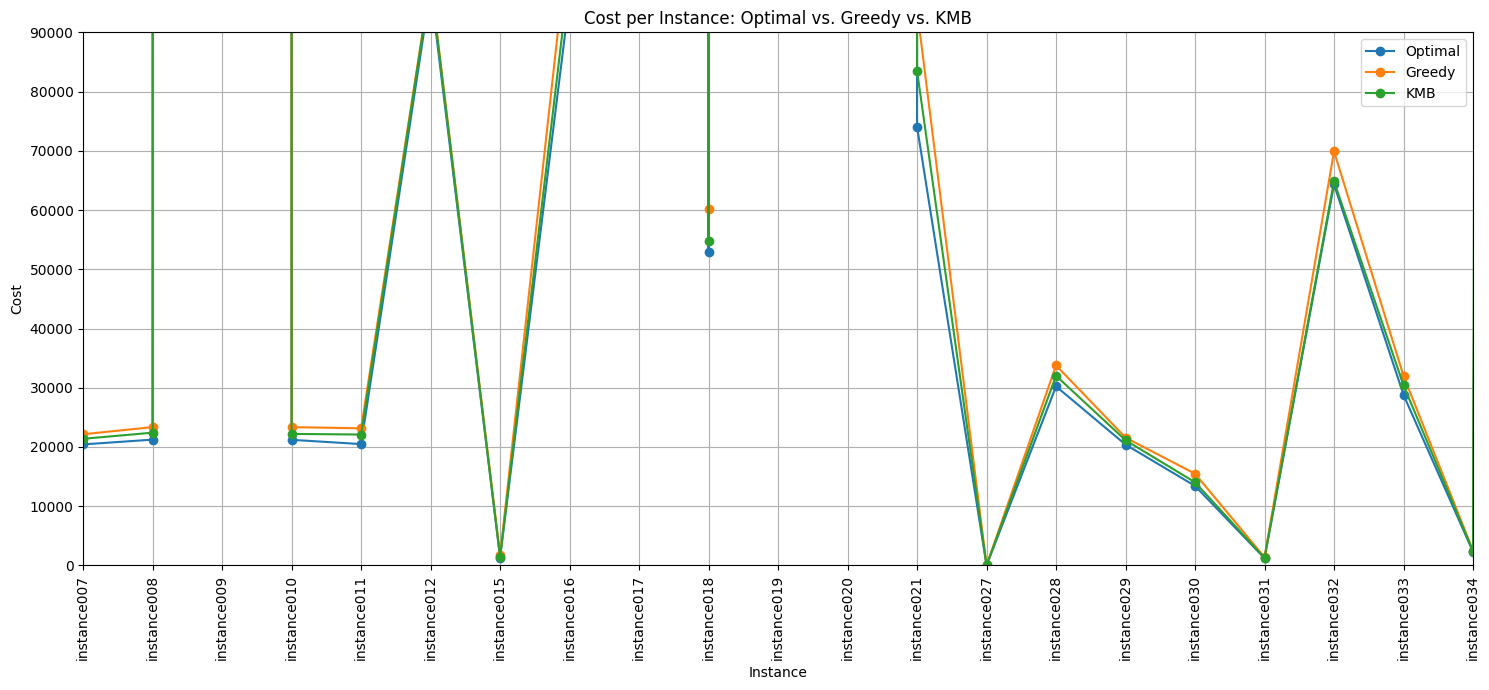

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Merge the greedy and KMB results
algorithm_results_df = pd.concat([greedy_results_df, kmb_results_df])

# Add optimal costs to the results DataFrame
algorithm_results_df['Optimal_Cost'] = algorithm_results_df['Instance'].map(optimal_costs)


# Sort by instance name for consistent plotting
algorithm_results_df = algorithm_results_df.sort_values(by='Instance')

# Create the plot
plt.figure(figsize=(15, 7))

# Plot optimal costs
plt.plot(algorithm_results_df['Instance'].unique(), algorithm_results_df.groupby('Instance')['Optimal_Cost'].first(), marker='o', linestyle='-', label='Optimal')


# Plot algorithm costs
for algorithm in algorithm_results_df['Algorithm'].unique():
    subset_df = algorithm_results_df[algorithm_results_df['Algorithm'] == algorithm]
    plt.plot(subset_df['Instance'], subset_df['Cost'], marker='o', linestyle='-', label=algorithm)

plt.xlabel('Instance')
plt.ylabel('Cost')
plt.title('Cost per Instance: Optimal vs. Greedy vs. KMB')
plt.xticks(rotation=90)
plt.xlim(6,26)
plt.ylim(0,90000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

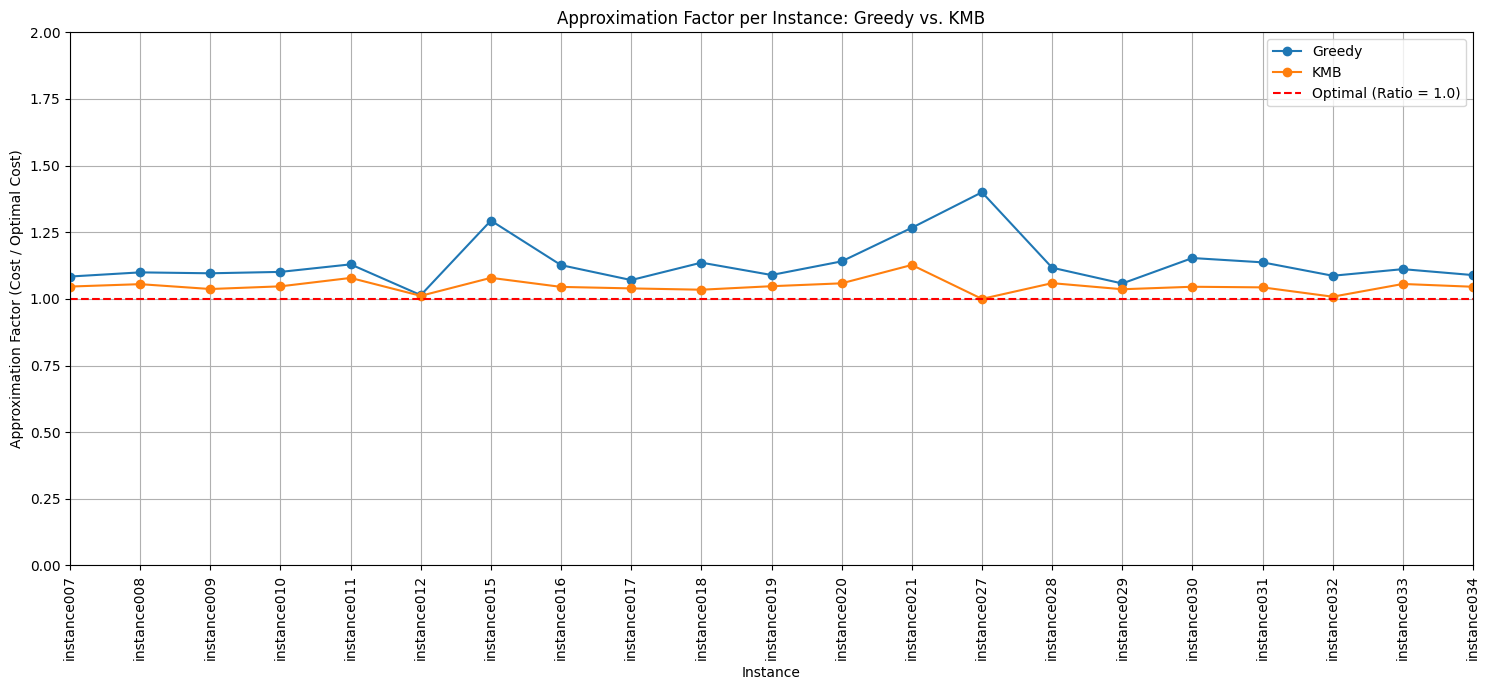

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate approximation ratio (Cost / Optimal Cost)
# Ensure to handle cases where Optimal_Cost might be zero or None to avoid division errors
all_results_df['Approximation_Ratio'] = all_results_df.apply(
    lambda row: row['Cost'] / row['Optimal_Cost'] if row['Optimal_Cost'] is not None and row['Optimal_Cost'] != 0 else float('inf'),
    axis=1
)

# Filter out instances where optimal cost is not available or approximation ratio is infinite
plot_approximation_df = all_results_df.replace([float('inf'), -float('inf')], pd.NA).dropna(subset=['Approximation_Ratio']).copy()

# Sort by instance name for consistent plotting
plot_approximation_df = plot_approximation_df.sort_values(by='Instance')

# Create the plot
plt.figure(figsize=(15, 7))

# Plot approximation ratio for each algorithm
for algorithm in plot_approximation_df['Algorithm'].unique():
    subset_df = plot_approximation_df[plot_approximation_df['Algorithm'] == algorithm]
    plt.plot(subset_df['Instance'], subset_df['Approximation_Ratio'], marker='o', linestyle='-', label=algorithm)

# Plot a line for the optimal solution (approximation factor of 1)
plt.axhline(y=1.0, color='r', linestyle='--', label='Optimal (Ratio = 1.0)')

plt.xlabel('Instance')
plt.ylabel('Approximation Factor (Cost / Optimal Cost)')
plt.title('Approximation Factor per Instance: Greedy vs. KMB')
plt.xlim(6,26)
plt.ylim(0,2)
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()